# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 10 декабря 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 10 декабря, -4 балла после 06:00 17 декабря, -6 баллов после 06:00 24 декабря -8 баллов  после 06:00 31 декабря

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 4] Фамилия Имя

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import DistanceMetric
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext cython
%load_ext pycodestyle_magic
%flake8_on

# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***

Задача 2.  ММП для многомерного нормального распределения.

Функция правдоподобия в общем случае записывается как:

$$ L(\theta) = p(X | \theta ) = \prod_{i=1}^N p(x_i | \theta)$$

Для многомерного нормального распределения плотность вероятности:
$$p(x_i| \theta) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}e^{-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)}$$

Выведите ММП оценку для вектора $\mu$


***Ваше решение здесь***

В случае многомерного нормального распределения набор параметров $\theta$ состоит из вектора средних $\mu$ и матрицы ковариаций $\Sigma$. Будем считать, что матрица ковариаций нам дана.


Перейдем к логарифму функции правдоподобия (это не изменит наш конечный результат, т.к. логарифмирование не изменит положение максимума ФП, ибо логарифм - монотонно возрастающая функция):

$$ \log L(\theta) = \sum_{i=1}^N \log p(x_i | \theta)$$

Заметим, что

$$\log p(x_i | \theta) = \log \left[ \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}e^{-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)} \right] =
- \frac{n}{2} \log (2\pi) - \frac{1}{2} \log |\Sigma|  -\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)$$


Максимум логарифма ФП будем искать стандартным способом: найдем производную по $\mu$ , приравняем к нулю и решим получившееся уравнение относительно $\mu$. Т.к. производная суммы равна сумме производных, то вначале найдем производную для *i*-го члена, а затем сложим. Для этого нам потребуется формула для производной квадратичной формы:

$$ \frac{d}{d x} x^T A x = x^T (A + A^T) $$

Если матрица $A$ - симметрична (к примеру, матрица ковариаций), то

$$ \frac{d}{d x} x^T A x = 2 x^T A $$

Возвращаемся к $\log p(x_i | \theta)$:

$$\frac {\partial} {\partial \mu} \log p(x_i | \theta) = \frac {\partial}{\partial \mu} \left[ -\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu) \right] = -\frac{2}{2} (x_i - \mu)^T \Sigma^{-1} =  (\mu - x_i )^T \Sigma^{-1}$$

Получаем:
$$ \log L(\theta) = \sum_{i=1}^N \log p(x_i | \theta) = \sum_{i=1}^N (\mu - x_i )^T \Sigma^{-1} = 
(N \mu^T - \sum_{i=1}^N x_i^T ) \Sigma^{-1}
$$

Приравниваем к нулю:

$$ (N \mu_{ML}^T - \sum_{i=1}^N x_i^T ) \Sigma^{-1} = 0$$


Матрица ковариаций положительная полуопределенная, стало быть и обратная ей матрица положительно полуопределена, поэтому мы можем упростить до:
$$ N \mu_{ML} = \sum_{i=1}^N x_i $$

Отсюда получаем оценку максимального правдоподобия,

$$ \mu_{ML} = \frac{1}{N} \sum_{i=1}^N x_i $$

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




Заметим, что для того, чтобы формулы Ланса-Вильямса были верны, необходимо, чтобы расстояние между $U$ и $V$ было минимальным среди всех попарных расстояний в данном множестве кластеров.

В таком случае для тройки $U, V, S$ возможны три ситуации: <br>
1. $d(U, \ S) < d(V,\ S)$
2. $d(U,\ S) > d(V,\ S)$
3. $d(U,\ S) = d(V,\ S)$

Раскроем модуль в формулах Ланса-Вильямса согласно данным неравенствам:

1.1.  $d_{min} =  \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) | = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  + \frac{1}{2} d_{\min}(U, S) - \frac{1}{2} d_{\min}(V, S) = d_{\min}(U, S)$
1.2. $ d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  - \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S) = d_{\max}(V, S)$

2.1. $d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} d_{\min}(U, S) + \frac{1}{2}  d_{\min}(V, S) = d_{\min}(V, S)$

2.2. $ d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} d_{\max}(U, S) - \frac{1}{2} d_{\max}(V, S) = d_{\max}(U, S)$

3.1. $d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)$

3.2. $ d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S) $

Для $d_{\min}$ для каждого из случаев выше можем заметить следующее:

1. По определению, $d_{\min}(U \cup V, S)$ соответствует минимальному расстоянию между объектами объединения $U \cup V$ и объектами $S$. Тогда, если $d_{\min}(U,\ S) < d_{\min}(V,\ S)$, то $d_{\min}(U \cup V, S) = d_{\min}(U, S)$ т.к. расстояние от любого объекта $V$ до любого объекта $S$ будет строго больше $d_{\min}(U, S)$.
2. По аналогии с первым пунктом, если $d_{\min}(U,\ S) > d_{\min}(V,\ S)$, то $d_{\min}(U \cup V, S) = d_{\min}(V, S)$ (просто поменяли $U$ и $V$ местами).
3. Если $d_{\min}(U,\ S) = d_{\min}(V,\ S)$, то $d_{\min}(U \cup V, S) = d_{\min}(U, S) = d_{\min}(V, S) = \frac{1}{2} (d_{\min}(U, S) + d_{\min}(V, S)) $


Пользуясь теми же самыми логическими рассуждениями, для $d_{\max}$:
1. По определению, $d_{\max}(U \cup V, S)$ соответствует максимальному расстоянию между объектами объединения $U \cup V$ и объектами $S$. Тогда, если $d_{\max}(U,\ S) < d_{\max}(V,\ S)$, то $d_{\max}(U \cup V, S) = d_{\max}(V, S)$ т.к. расстояние от любого объекта $V$ до любого объекта $S$ будет строго больше $d_{\max}(U, S)$.
2. Если $d_{max}(U,\ S) > d_{max}(V,\ S)$, то $d_{\max}(U \cup V, S) = d_{max}(U,\ S)$
3. Если $d_{max}(U,\ S) = d_{max}(V,\ S)$, то $d_{\max}(U \cup V, S) = d_{max}(U,\ S) = d_{\max}(V, S) = \frac{1}{2} (d_{\max}(U, S) + d_{\max}(V, S)) $

Сравнивая левые и правые части для всех шести случаев, получаем шесть равенств. ЧТД.

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

## Tree2labels

In [3]:
def tree2labels(Z, n_clusters):
    """
    Z - linkage matrix в формате
    """

    N = Z.shape[0]+1
    dct = {i: [i] for i in range(N)}

    children = Z[:, :2].astype(np.int32)

    for i in range(N-n_clusters):
        left = children[i][0]
        right = children[i][1]
        dct[N+i] = dct.pop(left) + dct.pop(right)

    preds = np.full(N, -1)
    assert len(dct) == n_clusters
    for i, klass in enumerate(dct):
        preds[dct[klass]] = i

    return preds

## Complete и average linkage

**Nearest-neighbor chain algorithm**

- Cоздаем стек S и список *активных* кластеров (т.е. с ненулевым размером) L. Вначале у нас n кластеров по одному объекту. Список L можно выполнить в виде массива sizes - при инактивации кластера будем просто обнулять его размер.
- Каждый раз, когда стек оказывается пустым, добавляем в него один активный кластер (неважно какой)

На каждой итерации (n-1):
- Снимаем кластер со стека (обозначим его как С)
- Обходим весь список активных кластеров, находим наиболее близкий к С кластер D
- Если D не лежит на верху стека, кладем D на стек и повторяем заново две пред. операции заново
- Если же D лежит на стеке, то объединяем C и D (ибо они взаимные ближайщие соседи), обновляем список активных кластеров - сохраняем новый кластер под индексом min(C, D), другой кластер обнуляем 
- Записываем индексы кластеров, расстояние, и размер в матрицу Z
- Обновляем матрицу расстояний между кластерами: для всех активных кластеров, кроме С, D, высчитываем новые расстояния

**Класс UnionFind**

После того, как мы нашли всю цепочку ближайщих соседей, нам необходимо переиндексировать правильным образом кластеры => кластеры, созданные на i-ой итерации построения дерева должны иметь индекс n+i.

Для этого мы будем использовать систему непересекающихся множеств, для которой определены две операции: объединения двух множеств и поиска множества для данного элемента.

In [4]:
def single_linkage(Dx, n):
    return nn_chain(Dx, n, method=0)

In [5]:
def complete_linkage(Dx, n):
    return nn_chain(Dx, n, method=1)

In [6]:
def average_linkage(Dx, n):
    return nn_chain(Dx, n, method=2)

In [7]:
%%cython --force
from numpy.math cimport INFINITY
import numpy as np
cimport numpy as np


# Функции для обновления расстояний между кластерами
"""
    d_xi : double
        Расстояние от кластера x до кластера i
    d_yi : double
        Расстояние от кластера x до кластера y
    d_xy : double
        Расстояние от кластера x до кластера y
    size_x : int
        Размер x
    size_y : int
        Размер y
    size_i : int
        Размер i
        
    Returns:
        Расстояние от кластера нового кластера x+y до кластера i
"""

cdef double single_distance(double d_xi, double d_yi,  double d_xy,
                            int size_x, int size_y, int size_i):
    return min(d_xi, d_yi)

cdef double complete_distance(double d_xi, double d_yi,  double d_xy,
                              int size_x, int size_y, int size_i):
    return max(d_xi, d_yi)

cdef double average_distance(double d_xi, double d_yi,  double d_xy,
                              int size_x, int size_y, int size_i):
    return (size_x * d_xi + size_y * d_yi) / (size_x + size_y)

# Функция для расчета индекса в condensed distance pairwise
cdef int condensed_index(int n, int i, int j):
    if i < j:
        return int(n * i - (i * (i + 1) / 2) + (j - i - 1))
    elif i > j:
        return int(n * j - (j * (j + 1) / 2) + (i - j - 1))
    else:
        msg = f'Cannot get the distance to the object itself! i = j = {i}'
        raise Exception(msg)


# тип указателя на функцию для обновления расстояний между кластерами
ctypedef double (*linkage_distance_update)(double d_xi, double d_yi,
                                           double d_xy, int size_x,
                                           int size_y, int size_i)

# 
cdef linkage_distance_update * linkage_methods = [
    single_distance, complete_distance, average_distance]

# Nearest-neighbor chain algorithm       
def nn_chain(distances, n, method):
    """
    distances - Pairwise distances
    
    Возвращает linkage matrix Z
    """

    cdef double[:] Dx = distances.copy()
    
    Z_arr = np.empty((n-1, 4))
    cdef double[:, :] Z = Z_arr
    
    cdef linkage_distance_update update_dist = linkage_methods[method]

    cdef int[:] stack = np.ndarray(n, dtype=np.int32)
    cdef int[:] sizes = np.ones(n, dtype=np.int32)
    cdef int stack_size = 0
    
    cdef int i, k, x, y, size_x, size_y, new_size
    cdef double d, curr_min
    
    for k in range(n-1):
        # Если стек пустой, добавим первый активный кластер
        if stack_size == 0:
            for i in range(n):
                if sizes[i] > 0:
                    stack[0] = i
                    stack_size = 1
                    break
        
        while True:            
            x = stack[stack_size-1] # size: {np.where(sizes == 0)[0]}
            
            if stack_size > 1:
                y = stack[stack_size-2]
                curr_min = Dx[condensed_index(n, x, y)]
            else: # не забываем обновить значение мин. растояния
                curr_min = INFINITY

            for i in range(n):
                # пропускаем текущий кластер
                # и неактивные кластеры
                
                if i == x or sizes[i] == 0:               
                    continue
                
                d = Dx[condensed_index(n, x, i)]

                if d < curr_min:
                    y = i
                    curr_min = d
            
            # Если пред. знач на стеке - ближ. сосед
            # выходим из цикла
            if stack_size > 1 and y == stack[stack_size - 2]:
                break
                
            # Если нет - ищем дальше
            stack[stack_size] = y
            stack_size += 1
        
        #  объединяем x и y
        if x > y:
            x, y = y, x
        
        stack_size -= 2
        size_x = sizes[x]
        size_y = sizes[y]
        new_size = sizes[x] + sizes[y]
                       
        Z[k, 0] = x
        Z[k, 1] = y
        Z[k, 2] = curr_min
        Z[k, 3] = new_size
        
        sizes[x] = 0
        sizes[y] = new_size
        
        # обновим расстояния
        for i in range(n):
            size_i = sizes[i]
            if i == y or size_i == 0:
                continue

            # d_xi, d_yi, d_xy,
            # size_x, size_y, size_i)
            Dx[condensed_index(n, i, y)] = update_dist(
                Dx[condensed_index(n, i, x)],
                Dx[condensed_index(n, i, y)],
                curr_min,
                size_x,
                size_y,
                size_i
            )
            
    # Отсортируем Z по расстоянию
    order = np.argsort(Z_arr[:, 2])
    Z_arr = Z_arr[order]
    
    # Найдем метки кластеров
    label(Z_arr, n)
    return Z_arr


cdef class UnionFind:
    """
    Система непересекающихся множеств c 
    операциями объединения двух множеств и
    поиска подмножества для данного элемента.

    В классе реализованы две операции:
        1. union(x, y) - объединяет два дочерних кластера
            x, y в один родительский
        2. find(x) - найти индекс родительского кластера для x

    Мы будем использовать UnionFind для
    последовательного объединения
    пар кластеров в новые кластеры.

    Два ближ. вершины ('ребенка')
    объединяются в одну вершину ('родитель').

    На i-ой операции будем создавать вершину
    под индексом N+i (начиная с i=0).
    
    parent : numpy.ndarray
        Массив, содержащий индексы родителей;
        parent[x] - родитель кластера x, parent[x] > x.
    
    size : numpy.ndarray
        Массив с размерами кластеров,
        size[x] - размер кластера x
        
    n : int
        Текущий номер итерации
    """

    cdef int[:] parent
    cdef int[:] size
    cdef int next_label

    def __init__(self, int n):
        self.parent = np.arange(2 * n - 1, dtype=np.intc)
        self.next_label = n
        self.size = np.ones(2 * n - 1, dtype=np.intc)

    cdef int union(self, int x, int y):
        # записываем индекс родителя
        self.parent[x] = self.next_label
        self.parent[y] = self.next_label
        
        cdef int size = self.size[x] + self.size[y]
        self.size[self.next_label] = size
        self.next_label += 1
        
        return size

    cdef find(self, int x):
        cdef int p = x
        
        # обходим массив родителей, находим корень
        # если у кластера родителя еще нет, то 
        # self.parent[x] == x
        while self.parent[x] != x:
            x = self.parent[x]
        
        # x - корень
        # меняем для всех узлов поддерева
        # непосредственного родителя
        # на корень
        while self.parent[p] != x:
            p = self.parent[p]
            self.parent[p] = x

        return x


cdef label(double[:, :] Z, int n):

    cdef UnionFind uf = UnionFind(n)

    cdef int i, x, y, x_root, y_root

    for i in range(n - 1):
        x, y = int(Z[i, 0]), int(Z[i, 1])
        
        x_root, y_root = uf.find(x), uf.find(y)
        
        if x_root < y_root:
            Z[i, 0], Z[i, 1] = x_root, y_root
        
        else:
            Z[i, 0], Z[i, 1] = y_root, x_root
        
        Z[i, 3] = uf.union(x_root, y_root)

## Класс Clustering

In [8]:
from sklearn.base import BaseEstimator, ClusterMixin


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according
    """

    def __init__(self,
                 n_clusters=2,
                 metric='euclidean',
                 linkage='single',
                 p=2.
                 ):
        """
        metric - string with name of metric, for example, euclidean
        Please add necessary algoritm parameters to class constructor.
        """
        self.n_clusters = n_clusters
        self.metric = metric
        self.linkage = linkage
        self.p = p

        if linkage == 'single':
            self.tree_builder = single_linkage
        elif linkage == 'complete':
            self.tree_builder = complete_linkage
        elif linkage == 'average':
            self.tree_builder = average_linkage
        else:
            raise Exception("Incorrect linkage method")

        self.Z = None

    def fit_predict(self, x, dist_matrix=None):
        """
        Use data matrix x to compute model parameters and predict clusters
        """
        size_x = x.shape[0]
        if dist_matrix is None:
            dist_matrix = distance.pdist(x, metric=self.metric, p=self.p)

        self.Z = self.tree_builder(dist_matrix, size_x)

        preds = tree2labels(self.Z, self.n_clusters)

        return preds

    def plot_dendrogram(self):
        """
        Try to visualize our data
        """
        if self.Z is None:
            raise ValueError('NotFitted')
        else:
            dn = dendrogram(self.Z)
            return dn

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

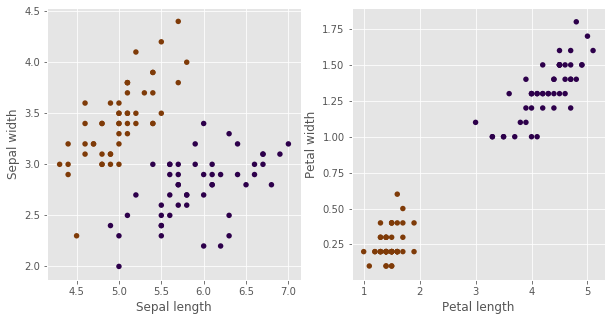

In [9]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [10]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2,
                                       compute_full_tree=True,
                                       linkage='single')
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print("Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

Sklearn AGGL score 1.0. Sklearn AGGL time 0.0013434886932373047


In [11]:
# Здесь предскажем кластера,
# посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering(
    linkage='complete')
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))

Our AGGL score 1.0. Our AGGL time 0.0017917156219482422


# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? 

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках.

In [12]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])

        if len(data) == 1:
            title = ''
        else:
            title = data[1]

        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [13]:
def process_group(kind='train'):

    if kind == 'train':
        filename = 'train_groups.csv'
    elif kind == 'test':
        filename = 'test_groups.csv'
    else:
        raise ValueError('Incorrect kind')

    data = pd.read_csv(filename)
    groups_titledata = {}

    for i in range(len(data)):
        new_doc = data.iloc[i]
        doc_group = new_doc['group_id']
        doc_id = new_doc['doc_id']
        title = doc_to_title[doc_id]

        if kind == 'train':
            target = new_doc['target']

        if doc_group not in groups_titledata:
            groups_titledata[doc_group] = []

        if kind == 'train':
            groups_titledata[doc_group].append((doc_id, title, target))
        elif kind == 'test':
            groups_titledata[doc_group].append((doc_id, title))

    return groups_titledata

In [14]:
traingroups_titledata = process_group('train')
testgroups_titledata = process_group('test')

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять, например, словами из тайтла.

Главное подобрать хорошую функцию расстояния между документами


Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

## Препроцессинг

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?',
          '|', ';', "'", '$', '&', '/', '[', ']', '>',
          '%', '=', '#', '*', '+', '\\', '•',  '~', '@',
          '£', '·', '_', '{', '}', '©', '^', '®', '`',
          '<', '→', '°', '€', '™', '›',  '♥', '←', '×',
          '§', '″', '′', 'Â', '█', '½', 'à', '…', '“',
          '★', '”', '–', '●', 'â', '►', '−', '¢', '²',
          '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦',
          '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：',
          '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨',
          '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è',
          '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓',
          '、', '│', '（', '»', '，', '♪', '╩', '╚', '³',
          '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
          '¹', '≤', '‡', '√', ]

In [17]:
def preprocess_text(text):
    text = text.lower()

    for punct in puncts:
        text = text.replace(punct, f' {punct} ')

    return text

In [18]:
def process_groups(groups):
    res = {}
    for group_id in groups:
        res[group_id] = [(doc_id, preprocess_text(title), *_)
                         for doc_id, title, *_ in groups[group_id]]
    return res   

In [19]:
traingroups_titledata = process_groups(traingroups_titledata)
testgroups_titledata = process_groups(testgroups_titledata)

## Векторизация

### Превратим данные по каждой из групп в массив индексов, список строк и массив значений таргета

In [20]:
def transform_group(group):
    ids = []
    strings = []
    target = []
    for doc_id, title, *_ in group:
        ids.append(doc_id)
        strings.append(title)
        if _:
            target.append(*_)

    if target:
        return np.array(ids, dtype=np.int32),\
               strings,\
               np.array(target, dtype=np.int32)
    else:
        return np.array(ids, dtype=np.int32),\
               strings

In [21]:
def transform_groups(groups):
    res = {}
    for group_id in groups:
        res[group_id] = transform_group(groups[group_id])

    return res

In [22]:
def vectorize_groups(vectorizer, data):
    res = {}
    for group_id in data:
        ids, strings, *_ = data[group_id]
        x = vectorizer.transform(strings)
        res[group_id] = ids, x.toarray(), *_

    return res

In [23]:
train_data = transform_groups(traingroups_titledata)
test_data = transform_groups(testgroups_titledata)

### Обучим векторизатор

#### Загрузим русские стоп-слова c [stopwords-ru](https://github.com/stopwords-iso/stopwords-ru/blob/master/stopwords-ru.txt)

In [24]:
with open('stopwords-ru.txt') as F:
    stop_words_ru = [line.strip() for line in F]

#### Приведем слова к нормальной форме

In [25]:
import pymorphy2

In [26]:
morph = pymorphy2.MorphAnalyzer()

In [27]:
_vectorizer = TfidfVectorizer()
sklearn_tokenizer = _vectorizer.build_tokenizer()

In [28]:
def lemmatize(text):
    words = sklearn_tokenizer(text)
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)

    return ' '.join(res)

In [29]:
def lemmatize_data(data):
    res = {}
    for group_id in data:
        ids, text, *target = data[group_id]
        text = [lemmatize(line) for line in text]
        if target:
            res[group_id] = ids, text, target[0]
        else:
            res[group_id] = ids, text
    return res

In [30]:
train_data_lemma = lemmatize_data(train_data)
test_data_lemma = lemmatize_data(test_data)

#### Объединим все заголовки

In [31]:
corpus = [lemmatize(preprocess_text(string))
          for string in doc_to_title.values()]

#### Создаем векторизатор

In [33]:
vectorizer_params = {
    'sublinear_tf': True,
    'min_df': 5,
    'stop_words': stop_words_ru,
    'lowercase': False,
}

In [34]:
vectorizer = TfidfVectorizer(**vectorizer_params)
vectorizer.fit(corpus);

/home/gennady/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['хотел'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
2:23: E703 statement ends with a semicolon


#### Векторизуем заголовки в группах

In [35]:
train_tfidf = vectorize_groups(vectorizer, train_data_lemma)
test_tfidf = vectorize_groups(vectorizer, test_data_lemma)

In [74]:
def filter_groups(vect_data):
    """Отфильтруем заголовки с нулевыми векторами"""
    res_filtered = {}
    res_zero = {}

    for group_id in vect_data:
        ids, X, *_ = vect_data[group_id]
        zero_rows = np.where(~X.any(axis=1))[0]
        nonzero_rows = np.where(X.any(axis=1))[0]

        if _:
            res_zero[group_id] = [
                                  ids[zero_rows],
                                  X[zero_rows],
                                  _[0][zero_rows]
                                 ]

            res_filtered[group_id] = [
                                  ids[nonzero_rows],
                                  X[nonzero_rows],
                                  _[0][nonzero_rows]
                                 ]

        else:
            res_zero[group_id] = [
                                  ids[zero_rows],
                                  X[zero_rows],
                                 ]

            res_filtered[group_id] = [
                                  ids[nonzero_rows],
                                  X[nonzero_rows],
                                 ]

    return res_filtered, res_zero

In [37]:
train_tfidf_filt, train_tfidf_zero = filter_groups(train_tfidf)
test_tfidf_filt, test_tfidf_zero = filter_groups(test_tfidf)

## Кластерный анализ

In [38]:
def perform_cluster_group(group, params):
    ids, X, *_ = group
    clustering = Clustering(**params)
    preds = clustering.fit_predict(X)
    tree = clustering.Z
    if _:
        return ids, tree, preds, _[0]
    else:
        return ids, tree, preds

In [39]:
def perform_cluster_groups(groups, params):
    res = {}
    for group_id in groups:
        res[group_id] = perform_cluster_group(groups[group_id], params)
    return res

In [40]:
def analyze_cluster(groups):
    mean_score = 0.
    total = 0
    res = {}
    for group_id in groups:
        preds = groups[group_id][2]
        true = groups[group_id][3]
        score = smt.f1_score(true, preds)
        res[group_id] = score
        total += preds.shape[0]
        mean_score += score*preds.shape[0]

    mean_score /= total

    return res, mean_score

In [41]:
params = {'metric': 'cityblock',
          'linkage': 'complete'}

In [42]:
train_cluster = perform_cluster_groups(train_tfidf_filt,
                                       params)

In [43]:
scores, mean_score = analyze_cluster(train_cluster)

In [44]:
mean_score

0.34894109969656006

### Посмотрим на дендрограммы групп с наилучшим и наихудшим  F1-score

In [45]:
max_cluster, min_cluster = \
    max(scores.items(), key=lambda x: x[1]),\
    min(scores.items(), key=lambda x: x[1])

Text(0.5, 1.0, 'Cluster 121 with max F1-score = 0.98')

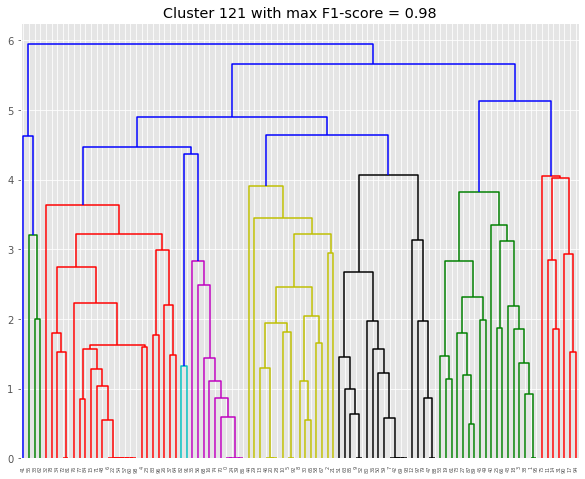

In [46]:
plt.figure(figsize=(10, 8))
dendrogram(train_cluster[max_cluster[0]][1])
plt.title(f'Cluster {max_cluster[0]} with max F1-score = {max_cluster[1]:.2f}')

Text(0.5, 1.0, 'Cluster 39 with min F1-score = 0.00')

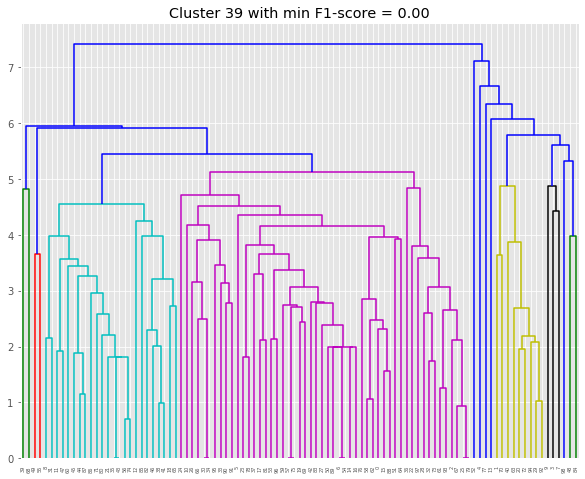

In [47]:
plt.figure(figsize=(10, 8))
dendrogram(train_cluster[min_cluster[0]][1])
plt.title(f'Cluster {min_cluster[0]} with min F1-score = {min_cluster[1]:.2f}')

### Объединим с отфильтрованными данными и посмотрим на F1

Отфильтрованные объекты мы будем относить к классу 0

In [48]:
from collections import defaultdict

In [49]:
def merge_results(cluster_res, data_zero):
    """Выбросим дендрограмму"""
    assert cluster_res.keys() == data_zero.keys()
    res = defaultdict(list)

    for group_id in cluster_res:
        # ids
        res[group_id].append(
            np.hstack([cluster_res[group_id][0],
                       data_zero[group_id][0]])
        )
        # dummy variable
        res[group_id].append(None)
        # preds
        res[group_id].append(
            np.hstack([cluster_res[group_id][2],
                       np.ones(data_zero[group_id][2].shape)])
        )

        # true
        res[group_id].append(
            np.hstack([cluster_res[group_id][3],
                       data_zero[group_id][2]])
        )

    return res        

In [50]:
train_merge_res = merge_results(train_cluster, train_tfidf_zero)

In [51]:
scores, mean_score = analyze_cluster(train_merge_res)

In [52]:
mean_score

0.3435536996738407

### Построим для каждой группы векторизатор

In [53]:
vectorizer_params2 = {
    'sublinear_tf': True,
    'min_df': 3,
    'stop_words': stop_words_ru,
    'lowercase': False,
}

In [54]:
def vectorizer_for_each_group(data):
    res = {}
    vectorizer = TfidfVectorizer(**vectorizer_params2)
    for group_id in data:
        ids, text, *_ = data[group_id]
        vector = vectorizer.fit_transform(text).toarray()
        if _:
            res[group_id] = ids, vector, _[0]
        else:
            res[group_id] = ids, vector

    return res   

In [55]:
train_each_vect = vectorizer_for_each_group(train_data_lemma)
test_each_vect = vectorizer_for_each_group(test_data_lemma)

/home/gennady/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['хотел'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/home/gennady/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['хотел'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [56]:
train_each_vect_filt, train_each_vect_zero = filter_groups(train_each_vect)
test_each_vect_filt, test_each_vect_zero = filter_groups(test_each_vect)

In [57]:
train_each_vect_cluster = perform_cluster_groups(train_each_vect_filt,
                                                 {'metric': 'cityblock',
                                                  'linkage': 'complete'})

In [58]:
scores, mean_score = analyze_cluster(train_each_vect_cluster)

In [59]:
mean_score

0.36248003234235604

In [60]:
train_merge_res = merge_results(train_each_vect_cluster, train_each_vect_zero)

In [61]:
scores, mean_score = analyze_cluster(train_merge_res)

In [62]:
mean_score

0.3058461540717301

### Найдем долю различных слов для заголовков каждой из групп

In [63]:
def condensed_index_(n, i, j):
    if i < j:
        return int(n * i - (i * (i + 1) / 2) + (j - i - 1))
    elif i > j:
        return int(n * j - (j * (j + 1) / 2) + (i - j - 1))
    else:
        msg = f'Cannot get the distance to the object itself! i = j = {i}'
        raise Exception(msg)


def diff_words_dist(corpus, normalize=False):
    n = len(corpus)
    D = np.zeros(n*(n-1)//2)
    for i in range(n):
        text_i = sklearn_tokenizer(corpus[i])
        words_i = set(text_i)

        for j in range(n):
            if i == j:
                continue
            text_j = sklearn_tokenizer(corpus[j])
            words_j = set(text_j)
            dist_ij = len(words_i.intersection(words_j))
            if normalize:
                dist_ij /= (len(words_i) + len(words_j))
            D[condensed_index_(n, i, j)] = dist_ij

    return D

In [64]:
def diff_word_groups(groups, normalize=False):
    res = {}
    for group_id in groups:
        res[group_id] = diff_words_dist(groups[group_id][1], normalize)
    return res        

In [65]:
# сжатые матрицы расстояний
train_diffword = diff_word_groups(train_data_lemma)

In [66]:
cluster_params = {'metric':  'cityblock',
                  'linkage': 'average'}

In [67]:
def cluster_diffword(groups, dists):
    # ids, tree, preds, target
    res = {}
    for group_id in groups:
        ids = groups[group_id][0]
        target = None
        if len(groups[group_id]) > 2:
            target = groups[group_id][2]

        cluster = Clustering(**cluster_params)
        preds = cluster.fit_predict(ids, dist_matrix=dists[group_id])

        if target.any():
            res[group_id] = (ids, cluster.Z, preds, target)
        else:
            res[group_id] = (ids, cluster.Z, preds)
    return res

In [68]:
train_cluster_diffword = cluster_diffword(train_data_lemma, train_diffword)

In [69]:
scores, mean_score = analyze_cluster(train_cluster_diffword)

In [70]:
mean_score

0.3677221479012375

Опять посмотрим на дендрограммы

In [71]:
max_cluster, min_cluster = \
    max(scores.items(), key=lambda x: x[1]),\
    min(scores.items(), key=lambda x: x[1])

Text(0.5, 1.0, 'Group 77 with max F1-score = 0.98')

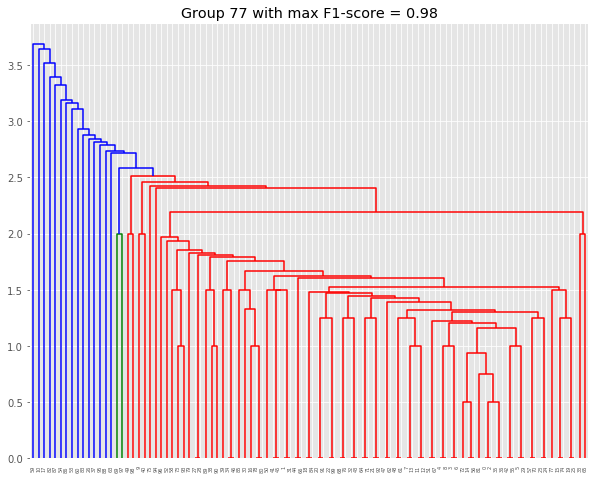

In [72]:
plt.figure(figsize=(10, 8))
dendrogram(train_cluster_diffword[max_cluster[0]][1])
plt.title(f'Group {max_cluster[0]} with max F1-score = {max_cluster[1]:.2f}')

Text(0.5, 1.0, 'Group 59 with min F1-score = 0.06')

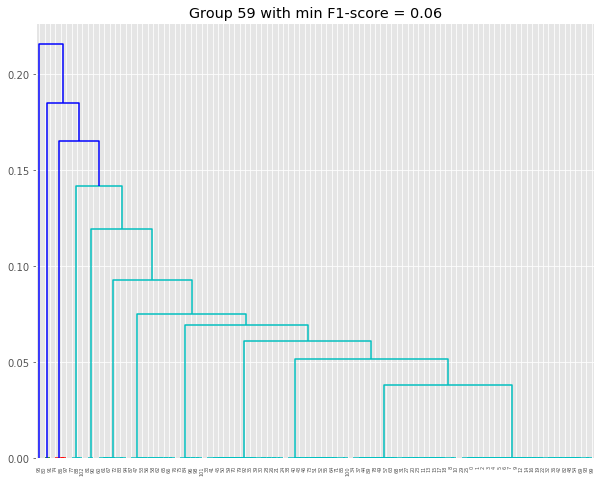

In [73]:
plt.figure(figsize=(10, 8))
dendrogram(train_cluster_diffword[min_cluster[0]][1])
plt.title(f'Group {min_cluster[0]} with min F1-score = {min_cluster[1]:.2f}')

## Выводы

1. Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

2. Наилучшим образом показали косинусное и манхэттеновское расстояния.

2. 0.36

4. Метки кластеров можно использовать в качестве признака.

Какой вывод еще можно сделать: использование tf-idf векторов, полученных на всем корпусе текстов, дает лучший результат по сравнению с векторами, полученными отдельно для каждой из групп. При этом использование числа общих слов в качестве функции расстояния дает лучший результат, чем tf-idf

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***